In [1]:
from __future__ import annotations
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)
from sklearn.inspection import permutation_importance
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
ARTIFACTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

In [2]:
df = pd.read_csv("S06-hw-dataset-03.csv")

print("Размер:", df.shape)

print("\nПервые 5 строк:\n", df.head())

print("\nРаспределение target:")
print(df["target"].value_counts(normalize=True).sort_index())

X = df.drop(columns=["id", "target"])
y = df["target"]

print("\nПризнаки:", X.columns.tolist())
print("Типы:", X.dtypes.unique())
print("Пропусков:", X.isnull().sum().sum())
feature_names = X.columns.tolist()

Размер: (15000, 30)

Первые 5 строк:
    id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -2.721419  0.652294  1.867234 -0.245331 -0.241182 -0.195509  1.180193   
1   2 -4.191520 -0.647731 -0.881929 -0.968159  3.530725 -4.858592  0.240979   
2   3 -0.582739  0.415128 -4.205613 -0.320853  0.313570 -2.655451  2.215387   
3   4 -1.766082  1.253523  1.610804  0.466067  3.837868 -3.564073 -1.831031   
4   5 -2.157834 -1.361285 -0.917199  0.937285  0.408551 -0.062032 -0.480196   

        f08       f09  ...       f20       f21       f22       f23       f24  \
0 -0.724816  1.804165  ...  0.042851 -0.153232  1.566167 -1.516125 -1.586857   
1 -0.714017  0.285769  ... -1.170056  0.631661  1.277915 -0.464432  1.927986   
2  1.492222 -0.516727  ...  0.083281 -0.757912  5.672669 -0.283472  0.275362   
3  1.066265 -0.198636  ... -0.674648  1.780285 -4.718432  0.711573  1.705610   
4 -0.554454 -1.026434  ... -0.096277  0.212875  1.710699  2.476220  0.669305   

      

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [4]:
def compute_metrics(y_true, y_pred, y_proba=None):
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro")),
        "roc_auc_ovr": float(roc_auc_score(y_true, y_proba, multi_class="ovr")) if y_proba is not None else None
    }

def evaluate_on_test(model, X_test, y_test, label):
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

In [5]:
results = []
best_models = {}
search_summaries = {}

# Dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

# Logistic Regression
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
lr_grid = {"lr__C": [0.1, 1.0, 10.0]}
lr_search = GridSearchCV(lr_pipe, lr_grid, cv=cv, scoring="roc_auc_ovr")
lr_search.fit(X_train, y_train)
best_models["LogReg(scaled)"] = lr_search.best_estimator_
search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_)
}
results.append(evaluate_on_test(lr_search.best_estimator_, X_test, y_test, "LogReg(scaled)"))

In [6]:
def run_search(label, estimator, param_grid):
    search = GridSearchCV(estimator, param_grid, cv=cv, scoring="roc_auc_ovr", n_jobs=-1)
    search.fit(X_train, y_train)
    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_)
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))

# Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
run_search("DecisionTree", dt, {
    "max_depth": [3, 5, 8, None],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.01]
})

# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
run_search("RandomForest", rf, {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", 0.5]
})

# HistGradientBoosting
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE, early_stopping=True)
run_search("HistGradientBoosting", hgb, {
    "learning_rate": [0.05, 0.1],
    "max_leaf_nodes": [15, 31],
    "max_depth": [3, None]
})

In [7]:
df_results = pd.DataFrame(results)
df_results.to_json(ARTIFACTS_DIR / "metrics_test.json", orient="records", indent=2)
with open(ARTIFACTS_DIR / "search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)

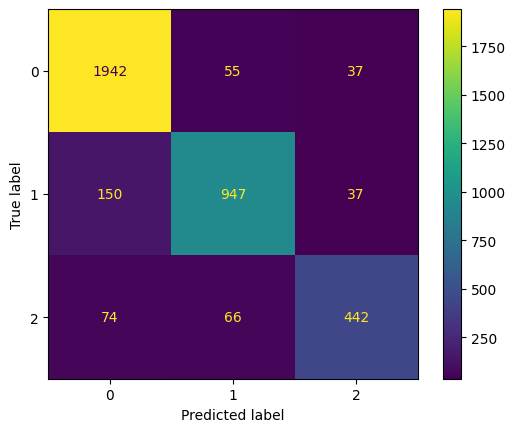

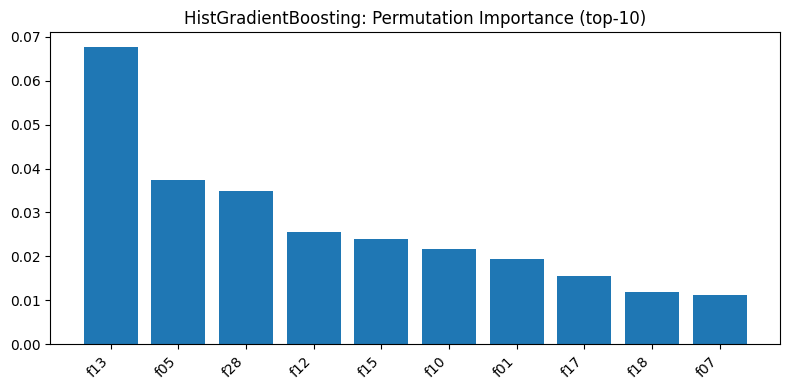

In [8]:
best_row = df_results.loc[df_results["roc_auc_ovr"].idxmax()]
best_label = best_row["model"]
best_model = best_models[best_label]

# Confusion Matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.savefig(FIGURES_DIR / "confusion_matrix.png")
plt.show()

# Permutation Importance
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=5, random_state=RANDOM_STATE,
    scoring="roc_auc_ovr"
)
idx = np.argsort(perm.importances_mean)[::-1][:10]
plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), perm.importances_mean[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=45, ha="right")
plt.title(f"{best_label}: Permutation Importance (top-10)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "permutation_importance.png")
plt.show()

In [9]:
joblib.dump(best_model, ARTIFACTS_DIR / "best_model.joblib")
meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label),
    "random_state": RANDOM_STATE
}
with open(ARTIFACTS_DIR / "best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)